<h1><center><font size="6">Predicting Telco Customer Churn</font></center></h1>

<h2><center><font size="4"> Kaggle </font></center></h2>

In [1]:
# The hyperparam only does the grid search but with precision_at_recall_threshold measure. The resampling is done outside

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)
1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate Reduce Memory](#3)

1. [Hyperparameter Tuning](#4)
    1. [Data Prep](#41)
        1. [Memory Footprint Reduction](#411)
        1. [Data Splitting](#412)
    1. [Search Algorithms - GridSearchCV](#42)

1. [Test Performance](#5)
    1. [Modelling Workflow](#51)
    
1. [Export Data, Pickled Model and Tuned Params](#6)

1. [References](#7)

## <a id='1'>Introduction</a>  
We will use the raw data to perform hyperparameter tuning on the Random Forest model after resampling

## <a id='2'>Initialization</a>  

### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os

import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") 
# Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [2]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Churn'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['No', 'Yes']

input_file_name =  'WA_Fn-UseC_-Telco-Customer-Churn.csv'

intermediate_data_path = '../intermediate data/'

# This will be used to compare resampling techniques
clean_df_file_name = intermediate_data_path + 'day1_cleaned_df_output_20200501.pkl'

# output_df_file_name = 'week4_cleaned_df_output_' 
tuned_model_params_name = 'week4_grid_search_rf_params_'
tuned_model_name = 'week4_rf_on_engineered_df_'

# Enter the date in which this notebook is run
export_date = '20200506'

In [3]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
import os
print(os.listdir('../input'))
# This will list all the files in this folder

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


## <a id='3'>Load Data & Validate</a>  

In [4]:
df = pd.read_csv('../input/' + input_file_name)
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
892,6259-WJQLC,Male,1,No,No,32,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),81.10,2619.25,No
2782,7037-MTYVW,Male,0,Yes,Yes,38,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),85.40,3297,No
5100,9940-RHLFB,Female,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Electronic check,75.30,75.3,Yes
2961,6898-MDLZW,Male,0,No,No,12,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,53.75,648.65,No
2996,6620-JDYNW,Female,0,No,No,18,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,Yes,Mailed check,60.60,1156.35,No


Lets check the head & tail to make sure there is nothing going on

In [5]:
df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [6]:
df.tail(3)
# similar logic here

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


No data corruption seen in either the head or the tail

In [7]:
# Lets see the data structure
df.info()
# They all seem to have been correctly read 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

All good to proceed

#### <a id = 31> Import cleaned dataframe

In [8]:
import pickle

infile = open(clean_df_file_name,'rb')
clean_df = pickle.load(infile)
infile.close()


## <a id='4'>Hyperparam Tuning</a>  

### <a id='41'>Data Prep

#### <a id='411'>Memory Footprint Reduction

In [9]:
from helper_functions_comprehensive import reduce_mem_usage_function
clean_df, NAlist = reduce_mem_usage_function(clean_df)

# Always reduce the dataset right after loading 
#even if you are sure that when exporting it you have reduced it
# This is because Pandas inflates the size of the data

Memory usage of dataframe is 1.13 MB
Column gender dtype after is float32 
******************************
Column SeniorCitizen dtype after is float32 
******************************
Column Partner dtype after is float32 
******************************
Column Dependents dtype after is float32 
******************************
Column tenure dtype after is float32 
******************************
Column PhoneService dtype after is float32 
******************************
Column MultipleLines dtype after is float32 
******************************
Column InternetService dtype after is float32 
******************************
Column OnlineSecurity dtype after is float32 
******************************
Column OnlineBackup dtype after is float32 
******************************
Column DeviceProtection dtype after is float32 
******************************
Column TechSupport dtype after is float32 
******************************
Column StreamingTV dtype after is float32 
*****************************

#### <a id='412'>Data Splitting

#### Feature - Target split

In [10]:
X = clean_df.drop(target_class_name, axis=1)
y = clean_df[target_class_name]

##### Train - Test Split

In [11]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print('Length of (train): {} | positives in y (train): {}'.format(len(X_train), sum(y_train)))
print('Length of (test): {} | positives in y (test): {}'.format(len(X_test), sum(y_test)))

Length of (train): 5625 | positives in y (train): 1495.0
Length of (test): 1407 | positives in y (test): 374.0


### <a id='42'>Search Algorithms - GridSearchCV

Q Why do you need to pass in your custom scoring function instead of the default?
Because grid search uses accuracy by default which we know ahead of time that its not the right metric for imbalanced datasets

https://stackoverflow.com/questions/32889929/gridsearchcv-scoring-parameter-using-scoring-f1-or-scoring-none-by-default-u

You have the option to select one of these built in scoring functions

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://www.kaggle.com/c/expedia-hotel-recommendations/discussion/21154

#### Import relevant libraries

In [12]:
from helper_functions_comprehensive import metrics_store_function, tune_grid_search_function

from sklearn.ensemble import RandomForestClassifier
# from collections import Counter

# This is for the hyperparam tuning and KFold CV
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# Classification metrics
from sklearn.metrics import precision_score, recall_score, f1_score, \
                        roc_auc_score, average_precision_score, fbeta_score

#### Upsample train fold

In [13]:
# Keep a holdout set that has not been sampled
cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42, stratify=y_train)

# Generate the resampled data using one of the imblearn methods
from imblearn.combine import SMOTEENN

# Upsample the train fold only before passing it on 
X_train_resampled, y_train_resampled = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)

#### Check out extent of overfitting

<module 'matplotlib.pyplot' from '/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py'>

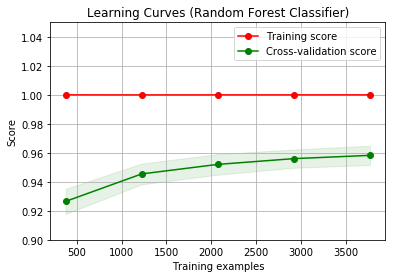

In [14]:
from sklearn.model_selection import learning_curve, ShuffleSplit
from helper_functions_comprehensive import plot_learning_curve

title = "Learning Curves (Random Forest Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

estimator = RandomForestClassifier(random_state=42)
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, 
                    ylim=(0.9, 1.05), cv=cv, n_jobs=4)
# This seems to be overfitting given the huge gap in train and test performance

<module 'matplotlib.pyplot' from '/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py'>

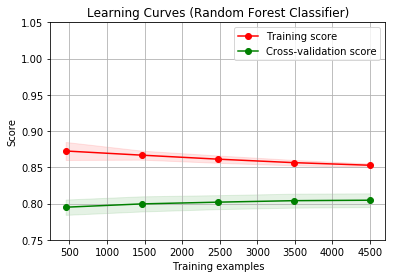

In [15]:
title = "Learning Curves (Random Forest Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

param_combo_dict = {'max_depth':10, 'min_samples_split':10, 'min_samples_leaf': 5}
estimator = RandomForestClassifier(random_state=42, **param_combo_dict)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.75, 1.05), cv=cv, n_jobs=4)

# You can see that constraining some of the parameters reduces overfitting at the cost of accuracy

#### Initialize the search space

In [16]:
# Higher Number of decision trees used in the ensemble will increase the accuracy
n_estimators = [10, 20, 50, 100, 200, 400]

# Increasing number of levels in tree may cause overfitting
max_depth = [5, 6, 7, 8, 9, 10, 11]

# Higher number of samples required to split a node will reduce overfitting
min_samples_split = [2, 5, 10, 20]

# Higher number of samples required at each leaf node will also reduce overfitting
min_samples_leaf = [1, 2, 5, 10, 20, 50]

# Create the grid for the random search. 
rf_params = {'n_estimators': n_estimators,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}

#### Tune the classifier

In [17]:
%%time
# For now, we will be keeping the same classifier as what was used in the previous weeks
classifier_type = RandomForestClassifier

hyperparam_results = tune_grid_search_function(X_train_resampled, y_train_resampled, 
                                               cv_fold_X_val, cv_fold_y_val,
                                                 rf_params, classifier_type = classifier_type)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

CPU times: user 10.9 s, sys: 1.14 s, total: 12 s
Wall time: 2min 54s


#### Display some binary classification metrics

In [18]:
classification_metrics_dict = hyperparam_results['classification_metrics']

######### Pretty print
print('---' * 45)
print('')

print("Accuracy: {}".format(round(classification_metrics_dict['accuracy'],4)))
print("Precision: {}".format(round(classification_metrics_dict['precision']),4))
print("Recall: {}".format(round(classification_metrics_dict['recall'],4)))
print("F1: {}".format(round(classification_metrics_dict['f1'],4)))
print("AUC ROC: {}".format(round(classification_metrics_dict['roc_auc'],4)))
print("F2: {}".format(round(classification_metrics_dict['f2'],4)))

#     print('Custom metric is {}'.format(hyperparam_results['custom_metric']))
print('---' * 45)



---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7964
Precision: 1.0
Recall: 0.7291
F1: 0.6556
AUC ROC: 0.775
F2: 0.7981
---------------------------------------------------------------------------------------------------------------------------------------


Check out how the best params look like

In [19]:
hyperparam_results

Counter({'internal_grid_search_scores': [0.9695550041813897,
          0.9739391928420216,
          0.9713730037930951,
          0.9743316812066012,
          0.974783248360284,
          0.9743329099469826,
          0.9703905850213589,
          0.9708317610519287,
          0.9756179119335456,
          0.975231124229332,
          0.975638769540093,
          0.9760866454091408,
          0.966997562683645,
          0.9716230296675272,
          0.9717145279928797,
          0.9751884311267917,
          0.9743571988127392,
          0.974783248360284,
          0.9659515690632287,
          0.9742914506483143,
          0.9721945172645791,
          0.9734807167308125,
          0.9756570791429179,
          0.9756583129467901,
          0.9641405578288492,
          0.9718302288855059,
          0.9717648586488354,
          0.9752541792912163,
          0.9752079745334886,
          0.975638769540093,
          0.9632206820876558,
          0.9691385142577563,
          0.973

In [20]:
len(hyperparam_results['internal_grid_search_scores'])
# This contains all average cv scores during the grid search

1008

#### Check out how CV performance increased over time

In [21]:
from sklearn.model_selection import ParameterGrid
param_combo_list = []
for combo in ParameterGrid(rf_params):
    param_combo_list.append(combo)

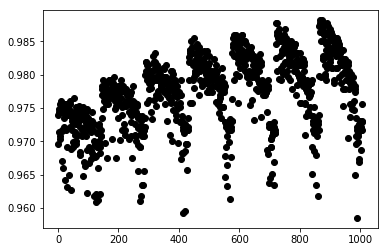

In [22]:
x = range(len(param_combo_list))

plt.plot(x, hyperparam_results['internal_grid_search_scores'], 'o', color='black');

In [23]:
# If you have more time, you can run a more refined grid search closer to the 'later' combo of params

## <a id = 5> Test Performance

### <a id='51'>Data Prepping</a> 

In [24]:
from imblearn.combine import SMOTEENN

# Upsample the train fold only before passing it on 
X_resampled_train, y_resampled_train = SMOTEENN(sampling_strategy = 
                                                'all', random_state=42).fit_sample(X_train, y_train)
print(X_resampled_train.shape,sum(y_resampled_train))

(4714, 19) 2530.0


### <a id='52'>Modelling Workflow </a> 

Lets use the best params found in the previous analysis

In [25]:
classifier = RandomForestClassifier(**hyperparam_results['best_params'], 
                                    n_jobs = -1, random_state=42)
# classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Has a Train accuracy of 98.0 % 
              precision    recall  f1-score   support

          No       0.99      0.98      0.98      2184
         Yes       0.98      0.99      0.99      2530

    accuracy                           0.98      4714
   macro avg       0.98      0.98      0.98      4714
weighted avg       0.98      0.98      0.98      4714

The ROC AUC Score on Train set is 1.0
Confusion matrix, without normalization
[[2140   44]
 [  28 2502]]


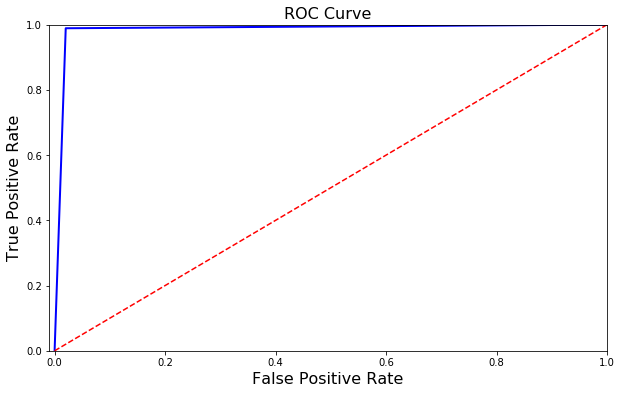

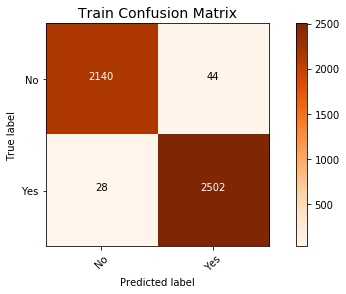

In [26]:
from helper_functions_comprehensive import custom_classification_metrics_function
custom_classification_metrics_function(X_resampled_train, y_resampled_train, labels, classifier, data_type='Train')

Has a Test accuracy of 75.0 % 
              precision    recall  f1-score   support

          No       0.88      0.77      0.82      1033
         Yes       0.52      0.71      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.75      0.76      1407

The ROC AUC Score on Test set is 0.82
Confusion matrix, without normalization
[[793 240]
 [109 265]]


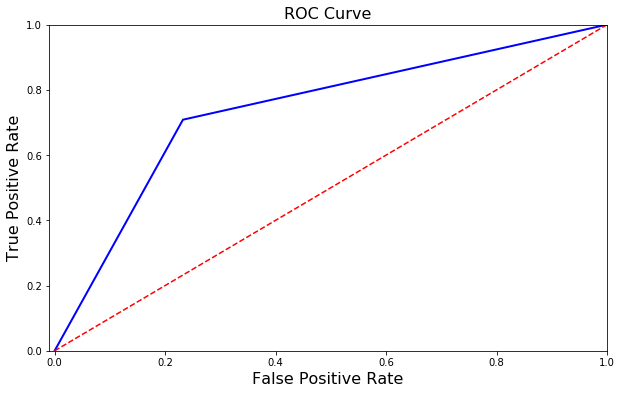

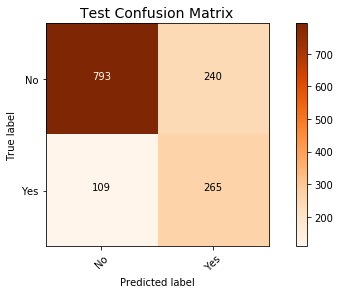

In [27]:
custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [28]:
from helper_functions_comprehensive import precision_at_recall_threshold_function

predicted_proba = classifier.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(
    y_test, predicted_proba, recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.4588744588744589


## <a id=6 >Export Data, Pickled Model and Tuned Params

In [29]:
import pickle
 
# Dump the tuned params 
pickle.dump(hyperparam_results['best_params'], 
            open(tuned_model_params_name + export_date + '.pkl', 'wb'))

# Dump the tuned model
pickle.dump(classifier, open(tuned_model_name + export_date + '.pkl', 'wb'))

## <a id=7 > References

F1 score vs ROC AUC
https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score

https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio#34698935

https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
